# Skipgrams over Skipgrams for Polyphonic Music (Polygrams)

## Setup

In [1]:
using DigitalMusicology

In [2]:
DigitalMusicology.usekern("/home/chfin/Uni/phd/data/csapp/mozart-piano-sonatas/");

In [3]:
# contains the "polygram" code
include("../src/polygrams.jl");
using Polygrams

## Analyzing a piece

In [4]:
prinnerpiece = "sonata03-2"
notes = getpiece(prinnerpiece, :notes_secs);

The notes are grouped to non-simultaneous note groups ("verticals")

In [5]:
mozverts = verticals(notes, 1.0, 2, 1.0);

Vertical groups are again grouped to skipgrams ("horizontals").
Output skipgrams are sampled with `p = 0.01`.

In [6]:
mozhoriz = horizontals(mozverts, 1.0, 4, 0.01);

The resulting horizontal groups are reduced to their pitch content (notes -> pitches),
each group is sorted by ascending pitch,
pitches are trasposed relative to the first pitch in the first group (reference pitch)
and converted to pitch classes (`schemarep`).
This allows to reproduce, which pc appeared in which voice, relative to the reference note.

The resulting "schema candidates" are counted (with equal weights for now) and the counts are stored in a trie:

In [7]:
counts = countschemas(mozhoriz);

The counted schema candidates are ranked by their counts.

In [8]:
ranks = rankcounts(counts)
topranks(ranks, 100);

102.0: [0, 5] -> [10, 2] -> [2, 7] -> [0, 5]
98.0: [0, 5] -> [9, 5] -> [10, 2] -> [2, 5]
98.0: [0, 5] -> [5, 5] -> [10, 2] -> [0, 5]
97.0: [0, 5] -> [10, 5] -> [10, 2] -> [5, 7]
93.0: [0, 5] -> [10, 5] -> [2, 7] -> [0, 5]
91.0: [0, 5] -> [10, 5] -> [7, 9] -> [0, 5]
84.0: [0, 7] -> [7, 0] -> [4, 7] -> [0, 0]
84.0: [0, 5] -> [10, 5] -> [10, 7] -> [0, 5]
82.0: [0, 8] -> [3, 8] -> [1, 5] -> [8, 10]
82.0: [0, 5] -> [2, 5] -> [10, 0] -> [0, 5]
80.0: [0, 5] -> [0, 5] -> [10, 2] -> [2, 5]
80.0: [0, 5] -> [5, 9] -> [9, 0] -> [5, 5]
79.0: [0, 5] -> [10, 5] -> [5, 7] -> [0, 5]
79.0: [0, 5] -> [9, 5] -> [10, 2] -> [5, 7]
78.0: [0, 5] -> [10, 5] -> [2, 5] -> [0, 5]
78.0: [0, 5] -> [5, 5] -> [10, 2] -> [5, 7]
77.0: [0, 5] -> [2, 5] -> [10, 7] -> [0, 5]
76.0: [0, 0] -> [5, 0] -> [5, 2] -> [7, 0]
76.0: [0, 5] -> [10, 5] -> [10, 0] -> [0, 5]
75.0: [0, 8] -> [1, 5] -> [8, 10] -> [3, 8]
74.0: [0, 0] -> [5, 9] -> [9, 2] -> [7, 0]
74.0: [0, 8] -> [1, 8] -> [5, 10] -> [3, 8]
73.0: [0, 8] -> [1, 5] -> [5, 10

As the schema candidates are dominated by artifacts (trills?), it is necessary to filter out the problematic cases.

In [9]:
# trill
istrill(cand) =
    all(stage -> all(p -> p==midi(2) || p==midi(0), stage), cand) ||
    all(stage -> all(p -> p==midi(10) || p==midi(0), stage), cand)

notrills = filter(r -> !istrill(r[1]), ranks)
topranks(notrills, 20)

102.0: [0, 5] -> [10, 2] -> [2, 7] -> [0, 5]
98.0: [0, 5] -> [9, 5] -> [10, 2] -> [2, 5]
98.0: [0, 5] -> [5, 5] -> [10, 2] -> [0, 5]
97.0: [0, 5] -> [10, 5] -> [10, 2] -> [5, 7]
93.0: [0, 5] -> [10, 5] -> [2, 7] -> [0, 5]
91.0: [0, 5] -> [10, 5] -> [7, 9] -> [0, 5]
84.0: [0, 7] -> [7, 0] -> [4, 7] -> [0, 0]
84.0: [0, 5] -> [10, 5] -> [10, 7] -> [0, 5]
82.0: [0, 8] -> [3, 8] -> [1, 5] -> [8, 10]
82.0: [0, 5] -> [2, 5] -> [10, 0] -> [0, 5]
80.0: [0, 5] -> [0, 5] -> [10, 2] -> [2, 5]
80.0: [0, 5] -> [5, 9] -> [9, 0] -> [5, 5]
79.0: [0, 5] -> [10, 5] -> [5, 7] -> [0, 5]
79.0: [0, 5] -> [9, 5] -> [10, 2] -> [5, 7]
78.0: [0, 5] -> [10, 5] -> [2, 5] -> [0, 5]
78.0: [0, 5] -> [5, 5] -> [10, 2] -> [5, 7]
77.0: [0, 5] -> [2, 5] -> [10, 7] -> [0, 5]
76.0: [0, 0] -> [5, 0] -> [5, 2] -> [7, 0]
76.0: [0, 5] -> [10, 5] -> [10, 0] -> [0, 5]
75.0: [0, 8] -> [1, 5] -> [8, 10] -> [3, 8]


In [10]:
# trill part
istrillpart(cand) =
    any(midis(0:11)) do trans
        count(stage -> all(p -> pc(p+trans) ∈ [midi(0), midi(2)], stage), cand) > 1
    end

notrillparts = filter(r -> !istrillpart(r[1]), notrills)
topranks(notrillparts, 20)

102.0: [0, 5] -> [10, 2] -> [2, 7] -> [0, 5]
98.0: [0, 5] -> [9, 5] -> [10, 2] -> [2, 5]
98.0: [0, 5] -> [5, 5] -> [10, 2] -> [0, 5]
97.0: [0, 5] -> [10, 5] -> [10, 2] -> [5, 7]
93.0: [0, 5] -> [10, 5] -> [2, 7] -> [0, 5]
91.0: [0, 5] -> [10, 5] -> [7, 9] -> [0, 5]
84.0: [0, 7] -> [7, 0] -> [4, 7] -> [0, 0]
84.0: [0, 5] -> [10, 5] -> [10, 7] -> [0, 5]
82.0: [0, 8] -> [3, 8] -> [1, 5] -> [8, 10]
82.0: [0, 5] -> [2, 5] -> [10, 0] -> [0, 5]
80.0: [0, 5] -> [0, 5] -> [10, 2] -> [2, 5]
80.0: [0, 5] -> [5, 9] -> [9, 0] -> [5, 5]
79.0: [0, 5] -> [10, 5] -> [5, 7] -> [0, 5]
79.0: [0, 5] -> [9, 5] -> [10, 2] -> [5, 7]
78.0: [0, 5] -> [10, 5] -> [2, 5] -> [0, 5]
77.0: [0, 5] -> [2, 5] -> [10, 7] -> [0, 5]
76.0: [0, 0] -> [5, 0] -> [5, 2] -> [7, 0]
76.0: [0, 5] -> [10, 5] -> [10, 0] -> [0, 5]
75.0: [0, 8] -> [1, 5] -> [8, 10] -> [3, 8]
74.0: [0, 0] -> [5, 9] -> [9, 2] -> [7, 0]


In [11]:
#fst = findfirsthoriz(mozverts, map(midis, [[0,4], [0,4], [0,5], [0,0]]), 1.0, 4, 1)
fst = findfirsthoriz(mozverts, notrillparts[1][1], 1.0, 1)

4-element Array{Array{DigitalMusicology.Notes.TimedNote{DigitalMusicology.Pitches.MidiPitch,Float64},1},1}:
 DigitalMusicology.Notes.TimedNote{DigitalMusicology.Pitches.MidiPitch,Float64}[Note<0.4166665-0.833333>(82), Note<0.833333-1.2499995>(77)]          
 DigitalMusicology.Notes.TimedNote{DigitalMusicology.Pitches.MidiPitch,Float64}[Note<1.2499995-1.666666>(79), Note<2.0833325-2.499999>(75)]          
 DigitalMusicology.Notes.TimedNote{DigitalMusicology.Pitches.MidiPitch,Float64}[Note<2.9166654999999997-3.333332>(72), Note<3.333332-3.7499985>(67)] 
 DigitalMusicology.Notes.TimedNote{DigitalMusicology.Pitches.MidiPitch,Float64}[Note<3.7499985-4.166665>(65), Note<3.7499985-5.4166644999999995>(70)]

In [12]:
schemarep(fst)

4-element Array{Array{DigitalMusicology.Pitches.MidiPitch,1},1}:
 DigitalMusicology.Pitches.MidiPitch[0, 5] 
 DigitalMusicology.Pitches.MidiPitch[10, 2]
 DigitalMusicology.Pitches.MidiPitch[2, 7] 
 DigitalMusicology.Pitches.MidiPitch[0, 5] 

In [13]:
using Plots
using MusicologyPlots
gr()

Plots.GRBackend()

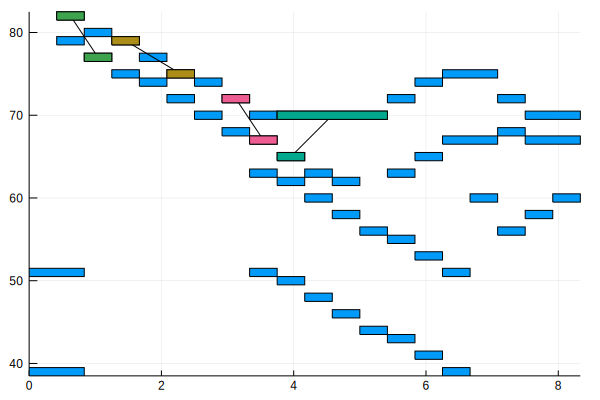

In [14]:
lower = onset(fst[1][1])
upper = maximum(map(offset, fst[4]))
isinrange(n) = onset(n) > lower-3.0 && offset(n) < upper+3.0
pianoroll(filter(isinrange, notes), legend=false, fmt=:svg)
plotschema!(fst)

In [15]:
savefig("skipgram_plot.pdf")